# Detrend Data<a id='top' class="tocSkip"> </a>

This tutorial shows how to detrend data - a commonly-used technique prior to detailed climate data analysis - using [CDAT](https://cdat.llnl.gov).

[Download this Jupyter Notebook](Detrend_data.ipynb)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-Notebook-and-Data" data-toc-modified-id="Prepare-Notebook-and-Data-1">Prepare Notebook and Data</a></span><ul class="toc-item"><li><span><a href="#Download-Data" data-toc-modified-id="Download-Data-1.1">Download Data</a></span></li><li><span><a href="#Open-Data-File,-Extract-Variable" data-toc-modified-id="Open-Data-File,-Extract-Variable-1.2">Open Data File, Extract Variable</a></span></li><li><span><a href="#Set-up-for-Demonstrating-That-Order-Matters-If-Missing-Data" data-toc-modified-id="Set-up-for-Demonstrating-That-Order-Matters-If-Missing-Data-1.3">Set-up for Demonstrating That Order Matters If Missing Data</a></span></li></ul></li><li><span><a href="#Test-case-1:-Removing-the-Annual-Cycle,-then-Creating-a-Time-Series" data-toc-modified-id="Test-case-1:-Removing-the-Annual-Cycle,-then-Creating-a-Time-Series-2">Test case 1: Removing the Annual Cycle, then Creating a Time Series</a></span></li><li><span><a href="#Test-case-2:-Creating-the-Time-Series,-then-Removing-the-Annual-Cycle" data-toc-modified-id="Test-case-2:-Creating-the-Time-Series,-then-Removing-the-Annual-Cycle-3">Test case 2: Creating the Time Series, then Removing the Annual Cycle</a></span></li><li><span><a href="#Detrend-Data" data-toc-modified-id="Detrend-Data-4">Detrend Data</a></span></li></ul></div>

## Prepare Notebook and Data
[Back to Top](#top)

In [1]:
from __future__ import print_function
import cdms2
import MV2
import genutil
import cdutil
import vcs
import os
import requests

### Download Data
The following NetCDF file contains Near-Surface Air Temperature data in degrees Kelvin (K) over North America. It is downloaded to the directory where this notebook is stored.

In [2]:
filename = 'tas_Amon_IPSL-CM5A-LR_1pctCO2_r1i1p1_185001-198912.nc'
if not os.path.exists(filename):
    r = requests.get("https://cdat.llnl.gov/cdat/sample_data/notebooks/{}".format(filename), stream=True)
    with open(filename,"wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:  # filter local_filename keep-alive new chunks
                f.write(chunk)

### Open Data File, Extract Variable
The following two lines of code open the file just downloaded to your local computer (`filename`), extract data for the Near-Surface Air Temperature (`tas`) and assign it to the variable `data`.

In [3]:
f = cdms2.open(filename)

data = f("tas")

The following line of code, allows us to take a quick look at the data using the `.info()` method.  

There are 1680 different time values which are measured as "days since 1850-01-01 00:00:00". The range of the time values is the difference between the last value (51084.5) and the first value (15.5) which equals 51069 days. If we divide this range by the number of values in the dataset (51069/1680) we get an average time duration for each data point of 30.398 days which tells us that we are working with monthly data.

Since this file is a subset of the globe, the data cover 13 latitude bands and 16 longitude values. The first and last values of latitude (~25.6 to ~48.3) and longitude (-123.75 to -67.5) tell us we are looking at the continental United States.

In [4]:
data.info()

*** Description of Slab tas ***
id: tas
shape: (1680, 13, 16)
filename: 
missing_value: 1e+20
comments: 
grid_name: <None>
grid_type: generic
time_statistic: 
long_name: Near-Surface Air Temperature
units: K
tileIndex: None
original_name: t2m
associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_IPSL-CM5A-LR_1pctCO2_r0i0p0.nc areacella: areacella_fx_IPSL-CM5A-LR_1pctCO2_r0i0p0.nc
coordinates: height
standard_name: air_temperature
cell_methods: time: mean (interval: 30 minutes)
cell_measures: area: areacella
history: 2011-03-07T11:45:34Z altered by CMOR: Treated scalar dimension: 'height'. 2011-03-07T11:45:34Z altered by CMOR: replaced missing value flag (9.96921e+36) with standard missing value (1e+20). 2011-03-07T11:45:34Z altered by CMOR: Inverted axis: lat.
Grid has Python id 0x123ce2320.
Gridtype: generic
Grid shape: (13, 16)
Order: yx
** Dimension 1 **
   id: time
   Designated a time axis.
   units:  days since 1850-01-01 00:00:0

### Set-up for Demonstrating That Order Matters If Missing Data

**INSERT NUMERICAL EXAMPLE HERE?**

First, to get a feel for the data, let's create a time series of the raw data that will span the entire 1680 time values in the data file. In creating this time series, the `averager` function will focus on a single time value at a time, will take the temperature data for the entire Earth for that time value and do a spatial average to yield a single global temperature value for each time value in the data set.

In [5]:
data_ts = genutil.averager(data, axis='xy')

In the next line of code, let's take a look at this time series of a single average temperature for the globe at each time value. Note the annual cycle and the warming trend over time.

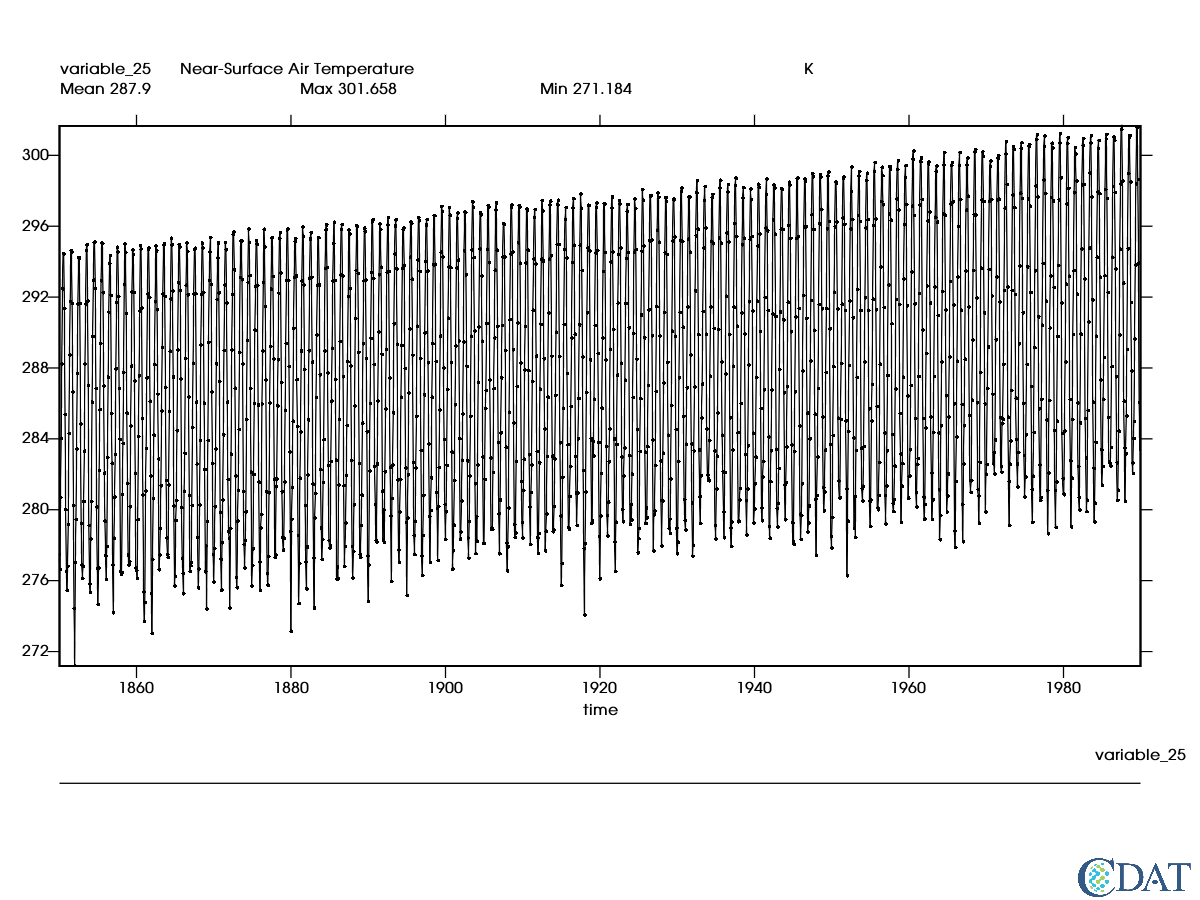

In [6]:
x = vcs.init(bg=True, geometry=(1200,900))
line = vcs.create1d()
line.markersize = .5
x.plot(data_ts, line)

Next, to demonstrate `genutil`'s capabilities and highlight that the order of operations matters for data where some values are missing, we'll try two test cases: 
1. removing the annual cycle from the data, then creating a time series and 
2. creating a time series, then removing the annual cycle.

First we need to create a dataset that has missing values, so we'll mask (delete) some data.

We'll delete, or mask, all data values that fall in the range between the maximum temperature of the dataset and 2 degrees less than the maximum temperature - `data.max()-2`. (All temperatures in the dataset are in degrees Kelvin (K).)

In [7]:
data_masked = MV2.masked_greater(data, data.max()-2)

## Test case 1: Removing the Annual Cycle, then Creating a Time Series
[Back to Top](#top)

First we will remove the annual cycle for these monthly data. Because the data are masked (i.e. some data are missing) the order of operation matters, as we will demonstrate.

In the next line of code, the ```ANNUALCYCLE.departures``` calculates the average monthly temperature value for each of the 12 months in a year over the complete time period for each location in the input data file and determines the departure of each temperature (at each time and location) from the average monthly value. 

For example, once an average January value for the entire dataset has been calculated, each January value in the dataset is subtracted from that average January value to yield a series of January departures for each year in the data set. Since there are 1680 months in the dataset, there are 1680/12 = 140 years of data, and therefore 140 January departures. Since there are 140 Februaries, 140 Marches, etc. there are 140 departures x 12 months = 1680 departures for each location in the dataset, as the ```.shape``` method shows (1680 departure values by 13 latitude bands, by 16 longitude values).

In [14]:
data_departures = cdutil.times.ANNUALCYCLE.departures(data_masked) # extract the departures of the masked data.

In [17]:
data_departures.shape

(1680, 13, 16)

The following line of code creates a time series of the data departures which spatially averages all the departures to a single global temperature value for each time value in the dataset, as the ```.shape``` method shows (i.e. there is no more latitude or longitude information).

In [18]:
data_departures_ts = genutil.averager(data_departures, axis='xy') # create time series of the data departures.

In [19]:
data_departures_ts.shape

(1680,)

Let's plot the resulting time series of the departures (i.e. the result of removing the annual cycle, then creating a time series). Notice how, with the annual cycle removed, it is easier to see the trend and the natural variability in the temperature values.

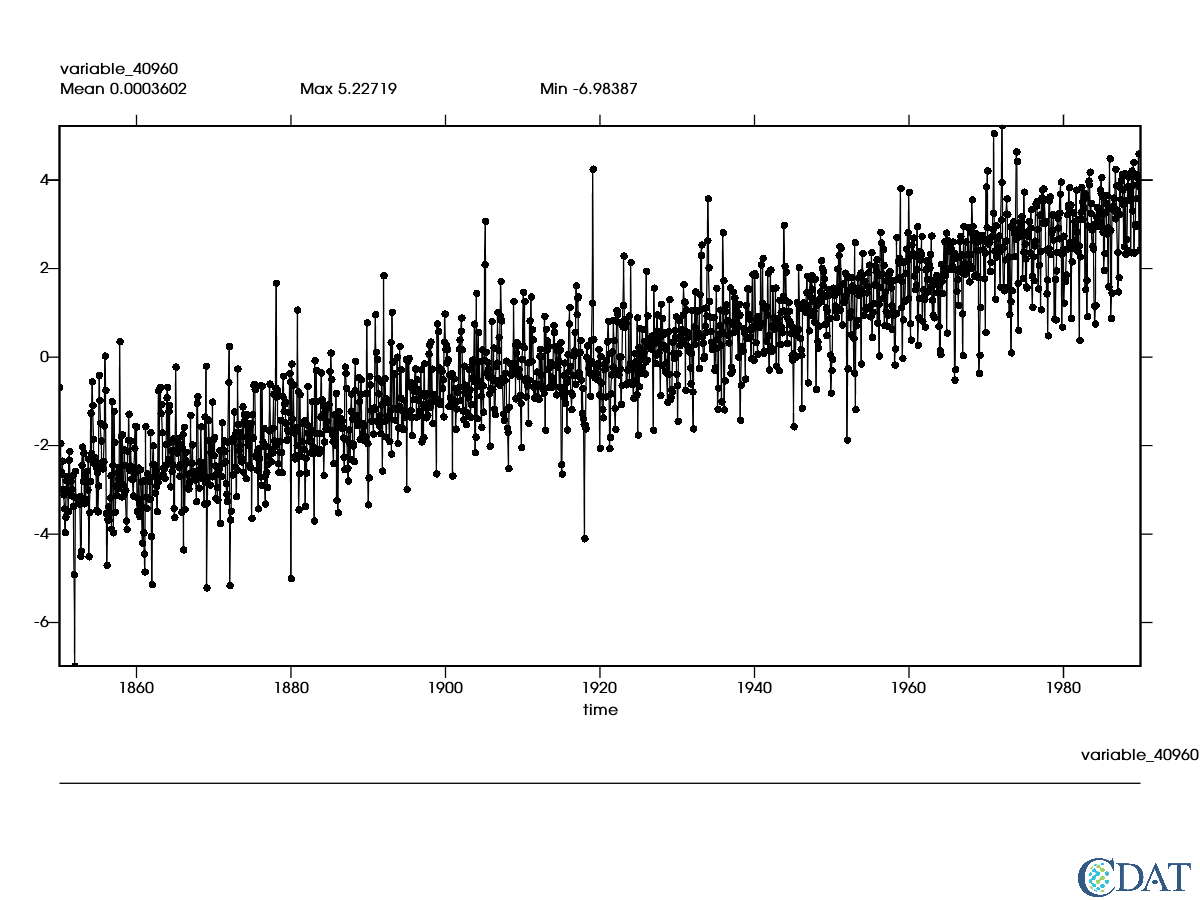

In [20]:
x.clear()
x.plot(data_departures_ts)

## Test case 2: Creating the Time Series, then Removing the Annual Cycle

Now let's calculate the time series, then remove the annual cycle and compare with the first test case.

As we did for the unmasked data above, the next line of code calculates the time series of the masked dataset by spatially averaging the temperature values at all latitude and longitude locations for each time value to give a single global temperature value for the masked dataset. (The .shape method, shows we are looking at 1680 values with no latitude or longitude, as expected.)

In [21]:
data_masked_ts = genutil.averager(data_masked, axis='xy')

In [25]:
data_masked_ts.shape

(1680,)

Let's take a look at this time series of the masked data. Note the trend and the annual cycle are similar to what we saw with the unmasked data.

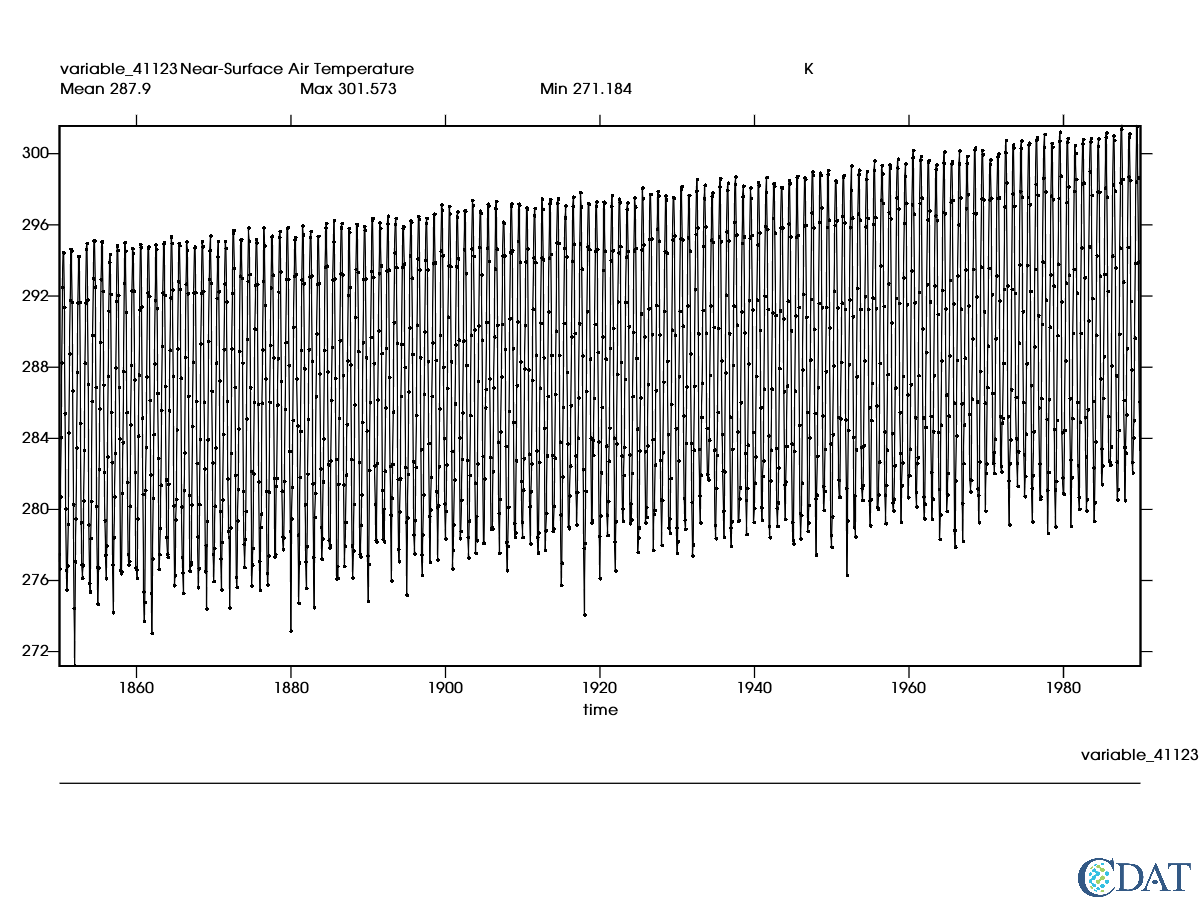

In [23]:
x = vcs.init(bg=True, geometry=(1200,900))
line = vcs.create1d()
line.markersize = .5
x.plot(data_masked_ts, line)

Next we'll remove the annual cycle by using the ```ANNUALCYCLE.departures``` method like we did in the first test case above. Again, the method calculates an average temperature value for each month of the year and determines the departure of the temperature at each time value from the average monthly temperature, effectively removing the annual cycle from the data. 

In [26]:
data_ts_departures = cdutil.times.ANNUALCYCLE.departures(data_masked_ts)

In [27]:
data_ts_departures.shape

(1680,)

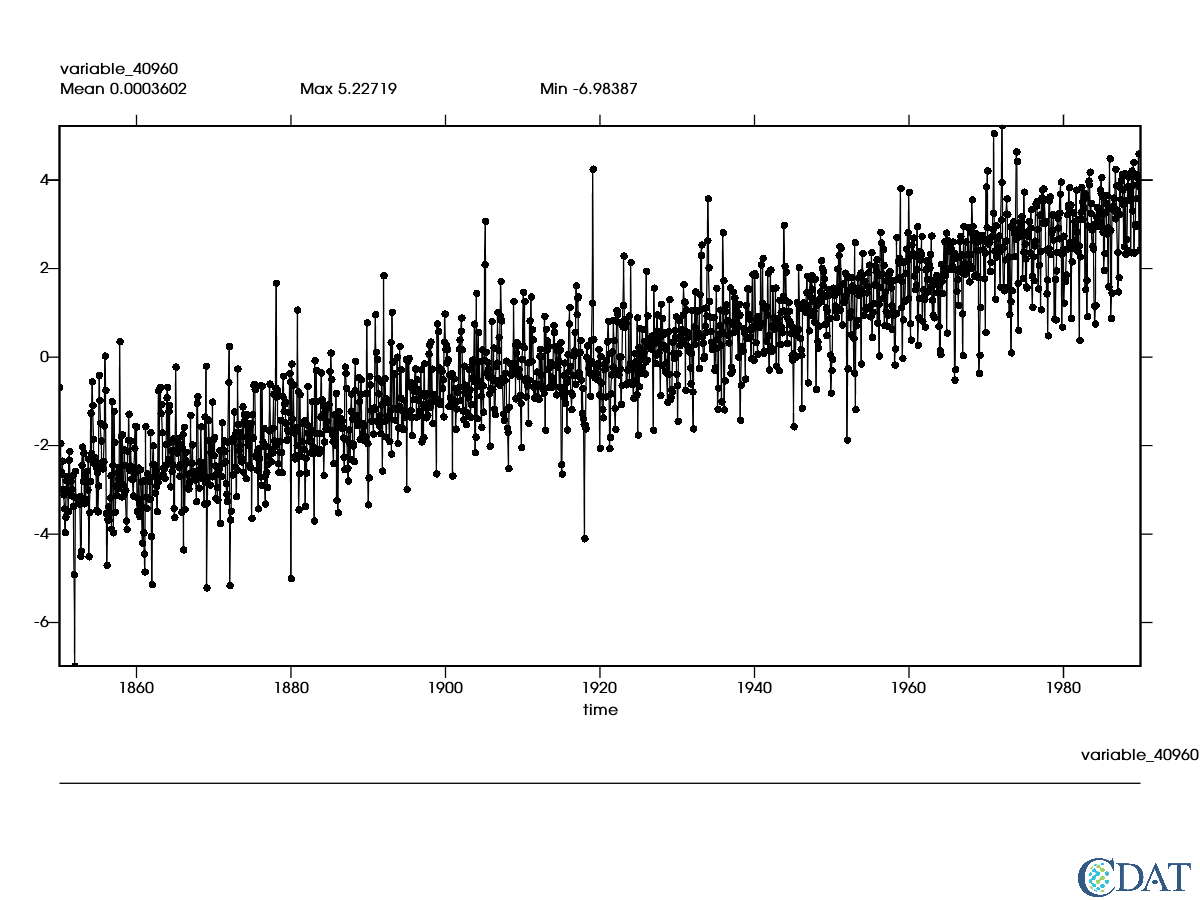

In [28]:
x.clear()
x.plot(data_departures_ts)

It is difficult to see the difference between the two test cases from the individual plots, so let's plot the difference between the end results from each test case: data_departures_ts (remove annual cycle (departures), then create time series (ts)) and data_ts_departures (create time series (ts), then remove annual cycle (departures)).

Please note the importance of the order of operation when missing data is present. The two time series are slightly different especially in the later years, where missing data occurs since more data values cross the temperature threshold to be removed (2 degrees cooler than the maximum temperature). If the order of operations did not matter, the two time series would be the same and the difference between the two would be zero for each time value.

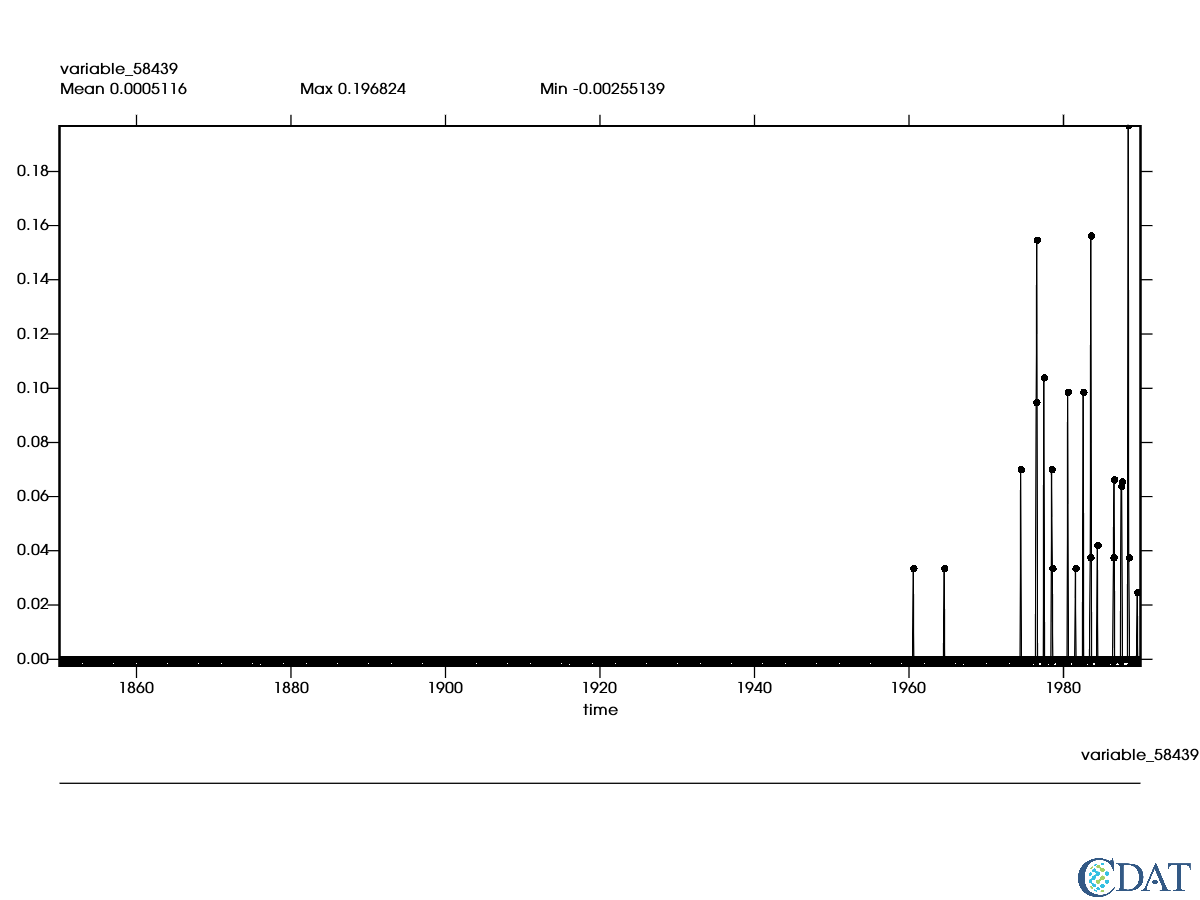

In [29]:
x.clear()
x.plot(data_departures_ts - data_ts_departures)

## Detrend Data
[Back to Top](#top)

First we will compute the trend over `time`. Note that the index of time can be anything; `genutil` will determine its index.

After computation we lose the time axis. Also note the units: since the time axis units are in `days since XXX`, the coeff/trend is in `K/day`.

In [30]:
coeff, intercept = genutil.statistics.linearregression(data_departures, axis="t")
print("Shapes: coeff {}, intercept {}".format(coeff.shape, intercept.shape))
# Let's do the same for the time series
coeff_ts, intercept_ts = genutil.statistics.linearregression(data_departures_ts, axis="t")

Shapes: coeff (13, 16), intercept (13, 16)


Now let's actually remove the trend.

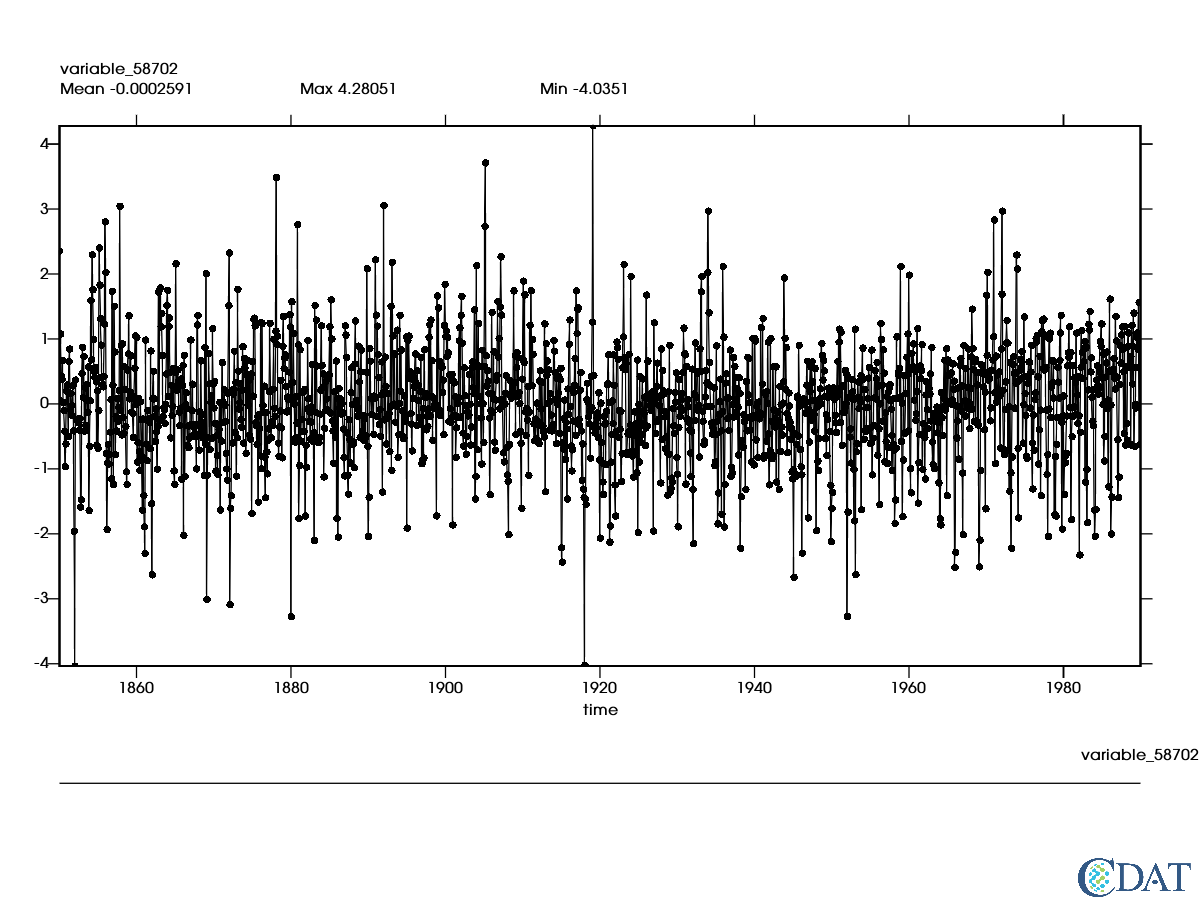

In [31]:
times = MV2.array(data_masked.getTime()[:])
times.setAxis(0, data_masked.getTime())

# since time is not necessarily on index 0 we need to use the grower function
# we use data as the first argument to ensure the same order
tmp, full_times = genutil.grower(data_departures, times)
# same for cefficient
tmp, coeff = genutil.grower(data_masked, coeff)
# same for intercept
tmp, intercept = genutil.grower(data_masked, intercept)

data_departures_detrend = data_departures - full_times * coeff - intercept
data_departures_ts_detrend = data_departures_ts - times * coeff_ts - intercept_ts
x.clear()
x.plot(data_departures_ts_detrend)

Here, again, the order matters.

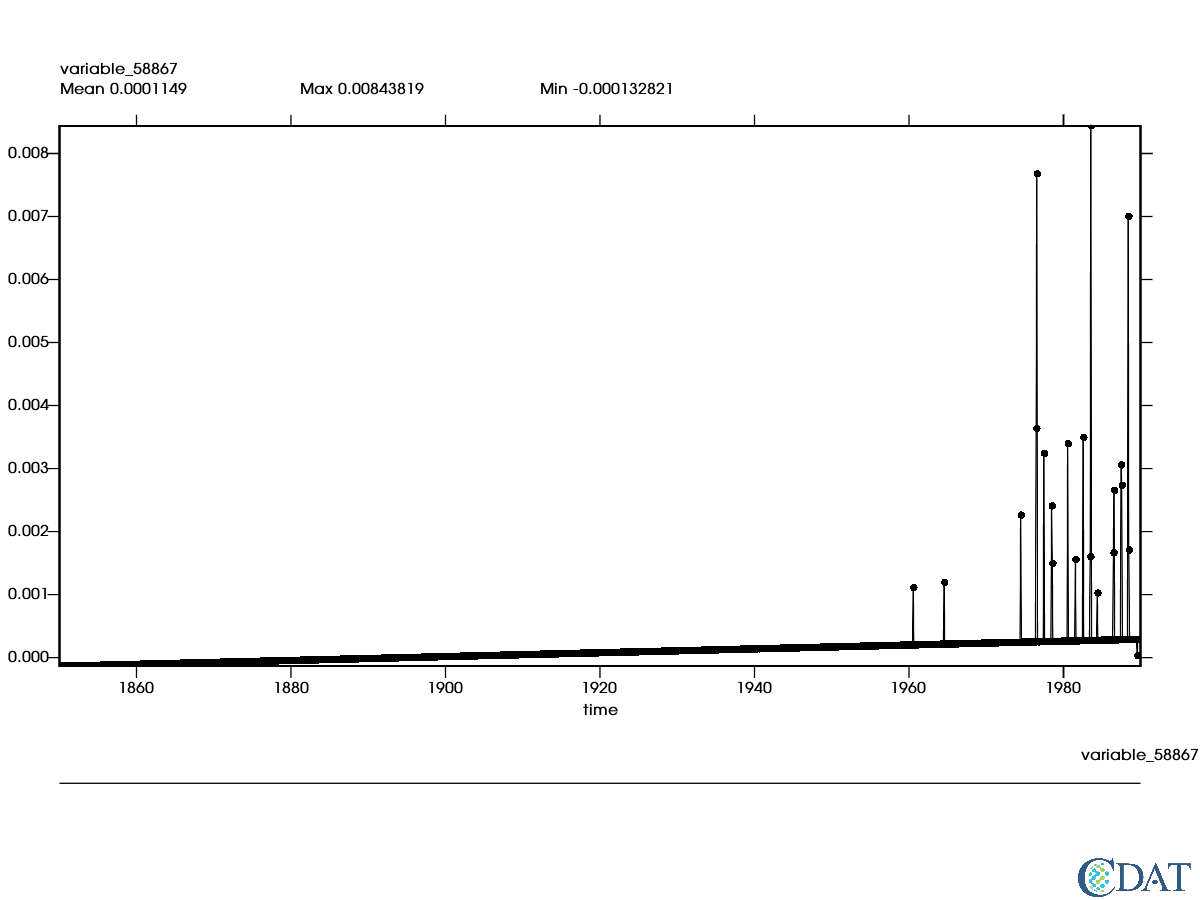

In [32]:
data_departures_detrend_ts = genutil.averager(data_departures_detrend, axis='xy')

x.clear()
x.plot(data_departures_detrend_ts - data_departures_ts_detrend)

The CDAT software was developed by LLNL. This tutorial was written by Charles Doutriaux and Holly Davis. This work was performed under the auspices of the U.S. Department of Energy by Lawrence Livermore National Laboratory under Contract DE-AC52-07NA27344.